In [1]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans,KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx

In [2]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv=pd.read_csv('data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("number of duplicate enterie:",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))
    

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Displaying a sub graph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


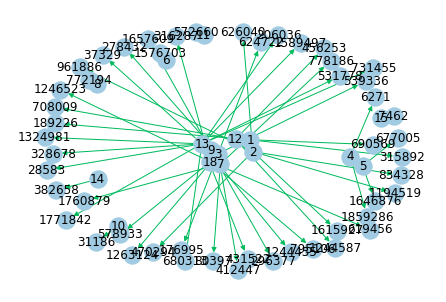

In [3]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('data/train.csv',nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1.Exploratory Data Analysis

In [4]:
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


# 1.1 No of followers for each person

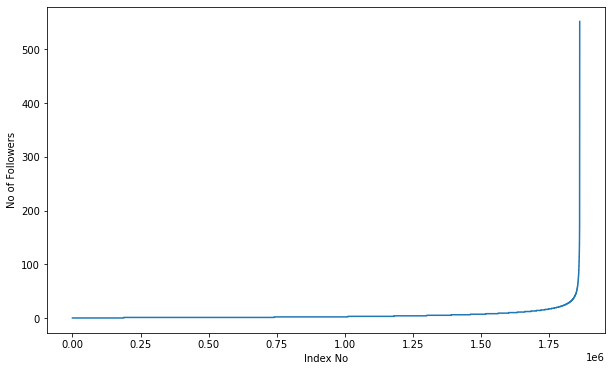

In [5]:
indegree_dist=list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

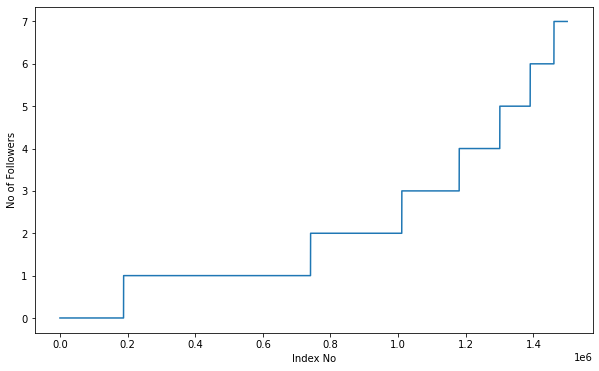

In [6]:
indegree_dist=list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

In [7]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


# 1.2 No of people each person is following

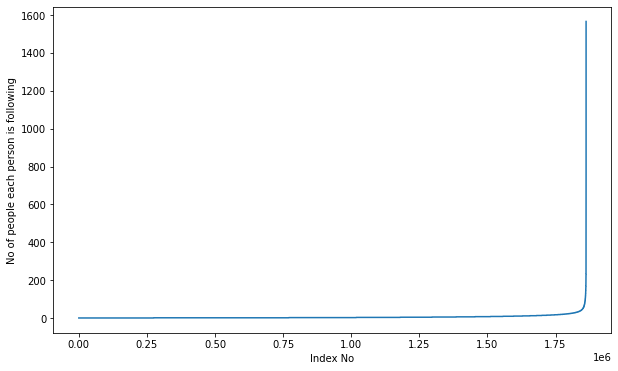

In [8]:
outdegree_dist=list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following')
plt.show()

In [9]:
for i in range(0,11):
    print(90+i,'percentile value is ',np.percentile(outdegree_dist,90+i))

90 percentile value is  12.0
91 percentile value is  13.0
92 percentile value is  14.0
93 percentile value is  15.0
94 percentile value is  17.0
95 percentile value is  19.0
96 percentile value is  21.0
97 percentile value is  24.0
98 percentile value is  29.0
99 percentile value is  40.0
100 percentile value is  1566.0


In [10]:
print('No of persons those are not following anyone are',sum(np.array(outdegree_dist)==0))
print('percentage of these people are',sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

No of persons those are not following anyone are 274512
percentage of these people are 14.741115442858524


In [11]:
print('No of persons those are not following anyone are',sum(np.array(indegree_dist)==0))
print('percentage of these people are',sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

No of persons those are not following anyone are 188043
percentage of these people are 10.097786512871734


In [12]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0:
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not following anyone and dont have any followers are ', count)

No of persons those are not following anyone and dont have any followers are  0


In [13]:
from collections import Counter
dict_in=dict(g.in_degree())
dict_out=dict(g.out_degree())
d=Counter(dict_in)+Counter(dict_out)
in_out_degree=np.array(list(d.values()))

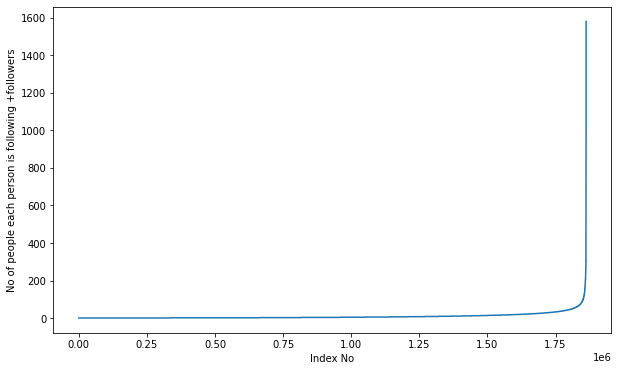

In [14]:
in_out_degree_sort=sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No of people each person is following +followers')
plt.show()

In [15]:
for i in range(0,11):
    print(90+i,'percentile value is ',np.percentile(in_out_degree_sort,90+i))

90 percentile value is  24.0
91 percentile value is  26.0
92 percentile value is  28.0
93 percentile value is  31.0
94 percentile value is  33.0
95 percentile value is  37.0
96 percentile value is  41.0
97 percentile value is  48.0
98 percentile value is  58.0
99 percentile value is  79.0
100 percentile value is  1579.0


In [16]:
print('Min of no of followers +following is ',in_out_degree.min());
print(np.sum(in_out_degree==in_out_degree.min()),'Persons having minimum no of followers+following')

Min of no of followers +following is  1
334291 Persons having minimum no of followers+following


In [17]:
print('Min of no of followers +following is ',in_out_degree.max());
print(np.sum(in_out_degree==in_out_degree.max()),'Persons having maximum no of followers+following')

Min of no of followers +following is  1579
1 Persons having maximum no of followers+following


# 2.Posing a Problem as a classification problem

# 2.1 Generating some edges which are not present in graph for supervised learning

Generated Bad links from graph which are not in graph and whose shortest path is greater than 2

In [19]:
## generating bad edges from given graph
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r=csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges=dict()
    for edge in r:
        edges[(edge[0],edge[1])]=1
    missing_edges=set([])
    while(len(missing_edges)<9437519):
        a=random.randint(1,1862220)
        b=random.randint(1,1862220)
        tmp=edges.get((a,b),-1)
        if tmp==-1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b)>2:
                    missing_edges.add((a,b))
                else:
                    continue
            except:
                    missing_edges.add((a,b))
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges=pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

In [26]:
len(missing_edges)

9437519

In [27]:

from sklearn.model_selection import train_test_split
if(not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda')):
    #reading total data df
    df_pos=pd.read_csv('data/train.csv')
    df_neg=pd.DataFrame(list(missing_edges),columns=['source_node','destination_node'])
    
    print("Number of nodes in the graph with edges",df_pos.shape[0])
    print("Number of nodes in the graph without edges",df_neg.shape[0])
    
    #train test split
    #splitted data into 80-20
    #positive links and negative links seperately because we need positive training data only for creating graph
    #and for feature generation
    X_train_pos,X_test_pos,y_train_pos,y_test_pos=train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2,random_state=9)
    X_train_neg,X_test_neg,y_train_neg,y_test_neg=train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2,random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges",X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges",X_train_neg.shape[0],"=",y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges",X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges",X_test_neg.shape[0],"=",y_test_neg.shape[0])
    
    
    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False,index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False,index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False,index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False,index=False)
else:
    #Graph from Training data only
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [30]:
if(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))
    
    #finding the unique nodes in the both train and test graphs
    train_nodes_pos=set(train_graph.nodes())
    test_nodes_pos=set(test_graph.nodes())
    trY_teY=len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN=len(train_nodes_pos-test_nodes_pos)
    teY_trN=len(test_nodes_pos-train_nodes_pos)
    print('no of people common in train and test --',trY_teY)
    print('no of people present in train but not present in test--',trY_teN)
    print('no of people present in test but not present in train--',teY_trN)
   

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test -- 1063125
no of people present in train but not present in test-- 717597
no of people present in test but not present in train-- 81498


In [41]:
  #final train and test sets
if(not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
( os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
( os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
( os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos=pd.read_csv('data/after_eda/train_pos_after_eda.csv',names=['source_node','destination_node'])
    X_test_pos=pd.read_csv('data/after_eda/test_pos_after_eda.csv',names=['source_node','destination_node'])
    X_train_neg=pd.read_csv('data/after_eda/train_neg_after_eda.csv',names=['source_node','destination_node'])
    X_test_neg=pd.read_csv('data/after_eda/test_neg_after_eda.csv',names=['source_node','destination_node'])
    
    print('='*60)
    print("Number of nodes in the train data graph with edges",X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges",X_train_neg.shape[0])
    print('='*60)
    
    print("Number of nodes in the test data graph with edges",X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges",X_test_neg.shape[0])
    
    X_train=X_train_pos.append(X_train_neg,ignore_index=True)
    Y_train=np.concatenate((y_train_pos,y_train_neg))
    X_test=X_test_pos.append(X_test_neg,ignore_index=True)
    Y_test=np.concatenate((y_test_pos,y_test_neg))
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)
    
    
    
    

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [42]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of target variable in train",Y_train.shape)
print("Shape of target variable in test",Y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of target variable in train (15100030,)
Shape of target variable in test (3775008,)
